In [1]:
import warnings                           
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import lag_plot
from itertools import product
from tqdm import tqdm_notebook

%matplotlib inline

from utils import mean_absolute_percentage_error, timeseries_train_test_split, train_test_split

from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

In [2]:
data = pd.read_excel('./data/день - количество блюд.xlsx', skiprows= 3, usecols= [0,1], names = ['date', 'meals'])
data.head()

,date,meals
0,2018-04-06 00:00:00,32.0
1,2018-04-07 00:00:00,8.0
2,2018-04-08 00:00:00,4.0
3,2018-04-09 00:00:00,14.0
4,2018-04-10 00:00:00,5.0


In [3]:
# remove the last row
data = data.iloc[:-1]

In [4]:
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')
data.head()

,meals
date,
2018-04-06,32.0
2018-04-07,8.0
2018-04-08,4.0
2018-04-09,14.0
2018-04-10,5.0


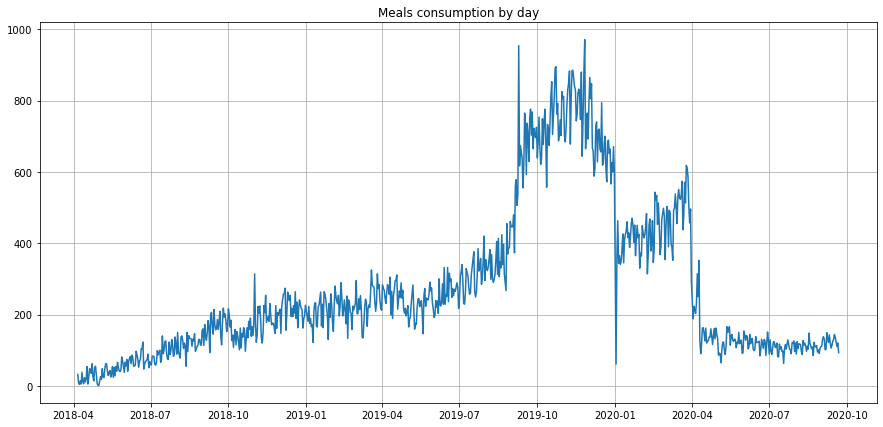

In [5]:
plt.figure(figsize=(15,7))
plt.plot(data)
plt.title('Meals consumption by day')
plt.grid(True)
plt.show()

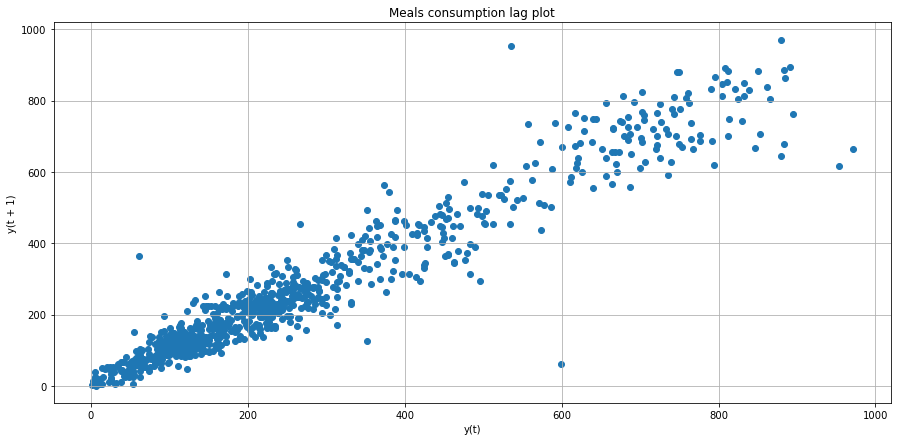

In [6]:
plt.figure(figsize=(15,7))
lag_plot(data)
plt.title('Meals consumption lag plot')
plt.grid(True)
plt.show()

In [7]:
time_data = pd.DataFrame(data.meals.copy())
time_data.columns = ["target"]

In [8]:
# Adding the lag of the target varable from 7 steps back (week) up to 30 (month)

for i in range(1, 21):
    time_data["lag_{}".format(i)] = time_data.target.shift(i)

In [9]:
time_data.tail(10)

,target,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20
date,,,,,,,,,,,,,,,,,,,,,
2020-09-12,106.0,122.0,143.0,122.0,133.0,149.0,102.0,101.0,131.0,138.0,...,111.0,110.0,105.0,91.0,101.0,95.0,113.0,109.0,110.0,122.0
2020-09-13,113.0,106.0,122.0,143.0,122.0,133.0,149.0,102.0,101.0,131.0,...,131.0,111.0,110.0,105.0,91.0,101.0,95.0,113.0,109.0,110.0
2020-09-14,125.0,113.0,106.0,122.0,143.0,122.0,133.0,149.0,102.0,101.0,...,138.0,131.0,111.0,110.0,105.0,91.0,101.0,95.0,113.0,109.0
2020-09-15,130.0,125.0,113.0,106.0,122.0,143.0,122.0,133.0,149.0,102.0,...,131.0,138.0,131.0,111.0,110.0,105.0,91.0,101.0,95.0,113.0
2020-09-16,144.0,130.0,125.0,113.0,106.0,122.0,143.0,122.0,133.0,149.0,...,101.0,131.0,138.0,131.0,111.0,110.0,105.0,91.0,101.0,95.0
2020-09-17,136.0,144.0,130.0,125.0,113.0,106.0,122.0,143.0,122.0,133.0,...,102.0,101.0,131.0,138.0,131.0,111.0,110.0,105.0,91.0,101.0
2020-09-18,123.0,136.0,144.0,130.0,125.0,113.0,106.0,122.0,143.0,122.0,...,149.0,102.0,101.0,131.0,138.0,131.0,111.0,110.0,105.0,91.0
2020-09-19,110.0,123.0,136.0,144.0,130.0,125.0,113.0,106.0,122.0,143.0,...,133.0,149.0,102.0,101.0,131.0,138.0,131.0,111.0,110.0,105.0
2020-09-20,120.0,110.0,123.0,136.0,144.0,130.0,125.0,113.0,106.0,122.0,...,122.0,133.0,149.0,102.0,101.0,131.0,138.0,131.0,111.0,110.0


In [10]:
time_data.shape

(897, 21)

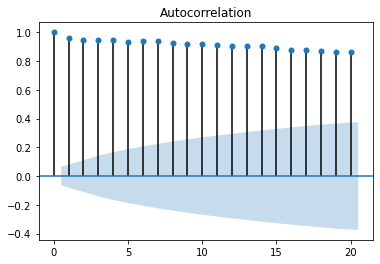

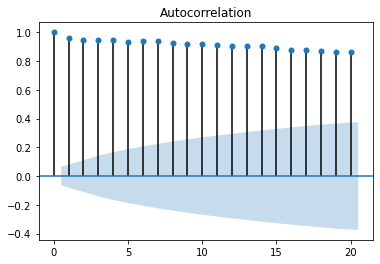

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(time_data['target'], lags=20)

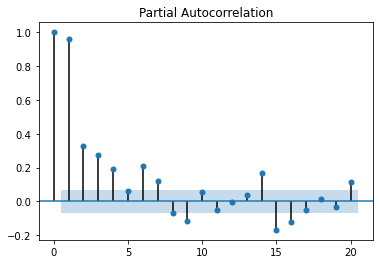

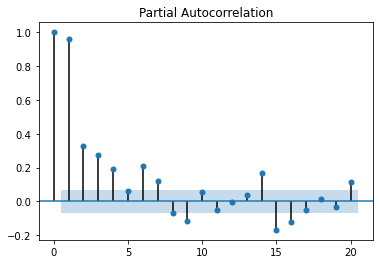

In [12]:
plot_pacf(time_data['target'], lags=20)

The partial autocorrelation function shows a high correlation with the first lag and lesser correlation with the second and third lag. The autocorrelation function shows a slow decay, which means that the future values have a very high correlation with its past values.

In [13]:
time_data['rolling_mean'] = time_data['target'].rolling(window=7).median()
time_data.tail()

,target,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,rolling_mean
date,,,,,,,,,,,,,,,,,,,,,
2020-09-17,136.0,144.0,130.0,125.0,113.0,106.0,122.0,143.0,122.0,133.0,...,101.0,131.0,138.0,131.0,111.0,110.0,105.0,91.0,101.0,125.0
2020-09-18,123.0,136.0,144.0,130.0,125.0,113.0,106.0,122.0,143.0,122.0,...,102.0,101.0,131.0,138.0,131.0,111.0,110.0,105.0,91.0,125.0
2020-09-19,110.0,123.0,136.0,144.0,130.0,125.0,113.0,106.0,122.0,143.0,...,149.0,102.0,101.0,131.0,138.0,131.0,111.0,110.0,105.0,125.0
2020-09-20,120.0,110.0,123.0,136.0,144.0,130.0,125.0,113.0,106.0,122.0,...,133.0,149.0,102.0,101.0,131.0,138.0,131.0,111.0,110.0,125.0
2020-09-21,93.0,120.0,110.0,123.0,136.0,144.0,130.0,125.0,113.0,106.0,...,122.0,133.0,149.0,102.0,101.0,131.0,138.0,131.0,111.0,123.0


In [14]:
tscv = TimeSeriesSplit(n_splits=5)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(time_data)

In [16]:
print(X_train.shape, X_test.shape)

(613, 21) (264, 21)


In [17]:
def linear_regression_model(X_train, y_train):
    
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    
    return lr

In [18]:
lr = linear_regression_model(X_train, y_train)

In [19]:
def plotModelResults(model, X_train, X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

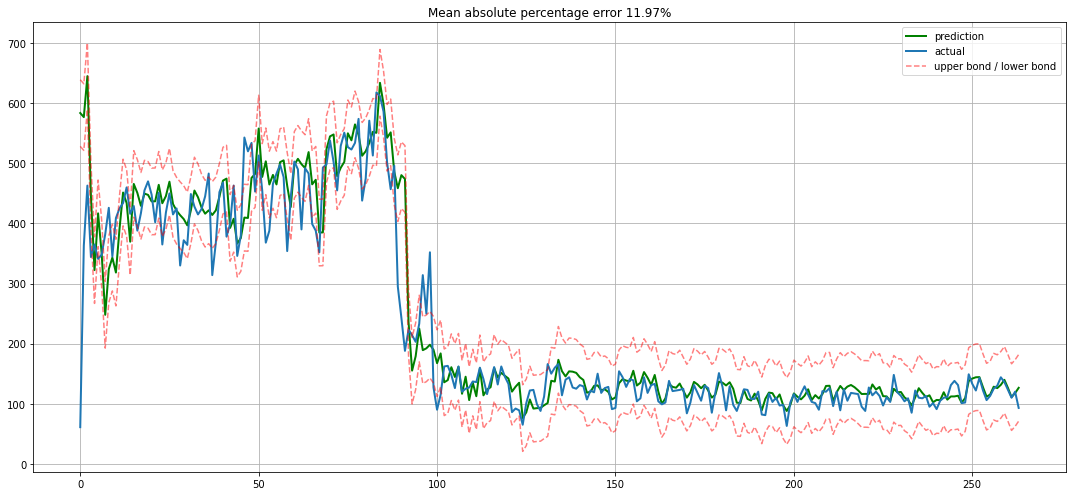

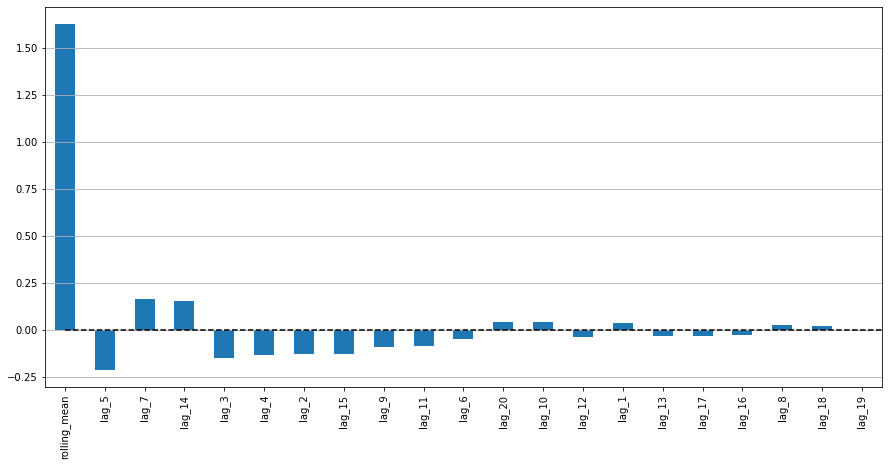

In [20]:
plotModelResults(lr, X_train, X_test, plot_intervals=True)
plotCoefficients(lr)

### Regularization and feature selection

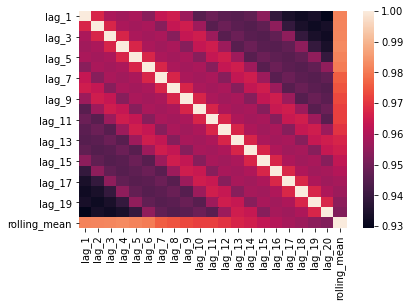

In [21]:
sns.heatmap(X_train.corr());

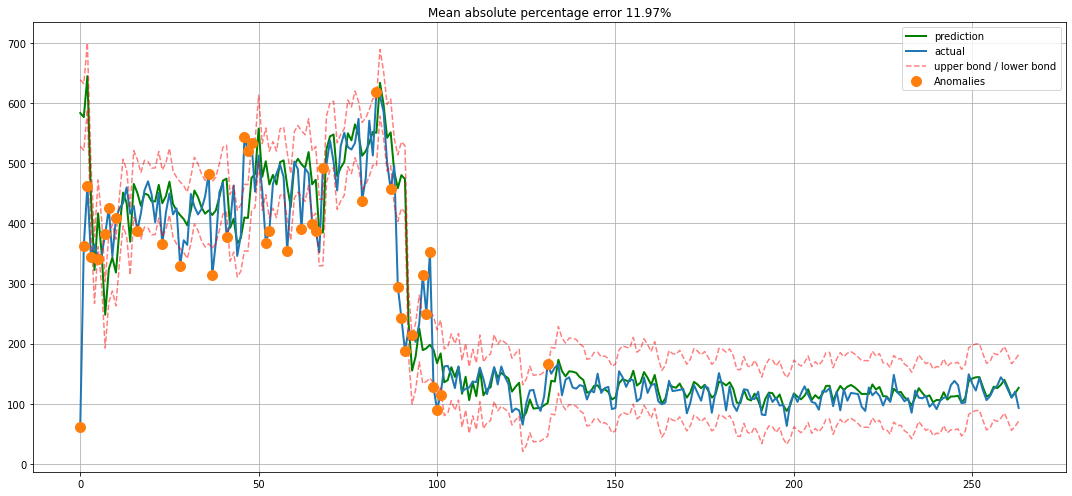

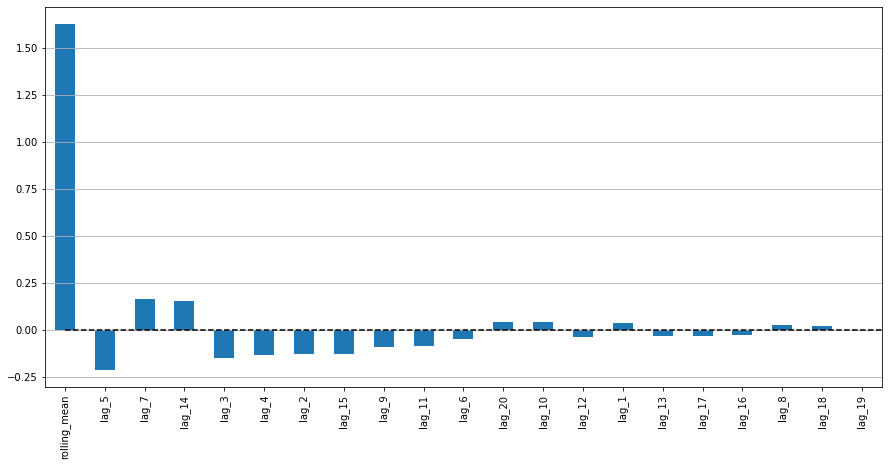

In [22]:
from sklearn.linear_model import LassoCV, RidgeCV

ridge = RidgeCV(cv=tscv)
ridge.fit(X_train, y_train)

plotModelResults(ridge, 
                 X_train=X_train, 
                 X_test=X_test, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(ridge)

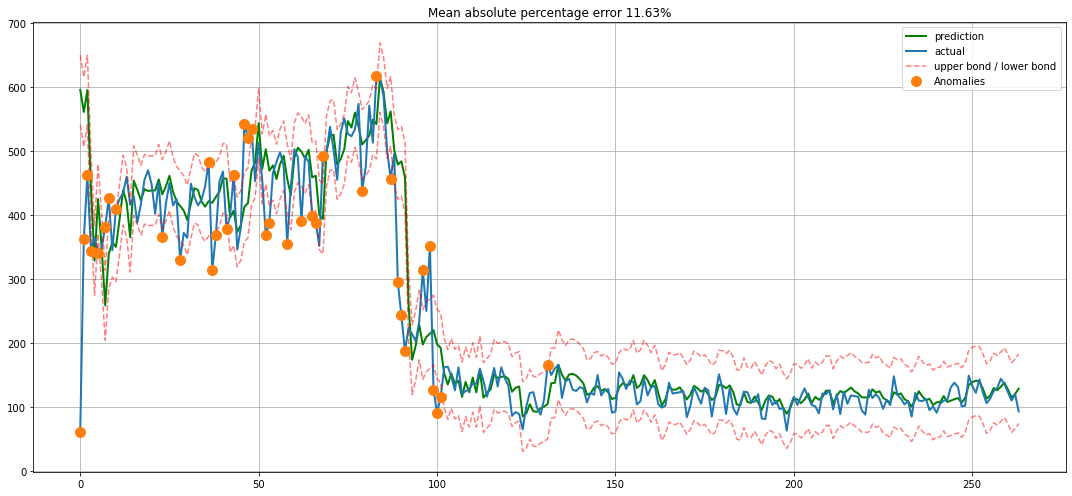

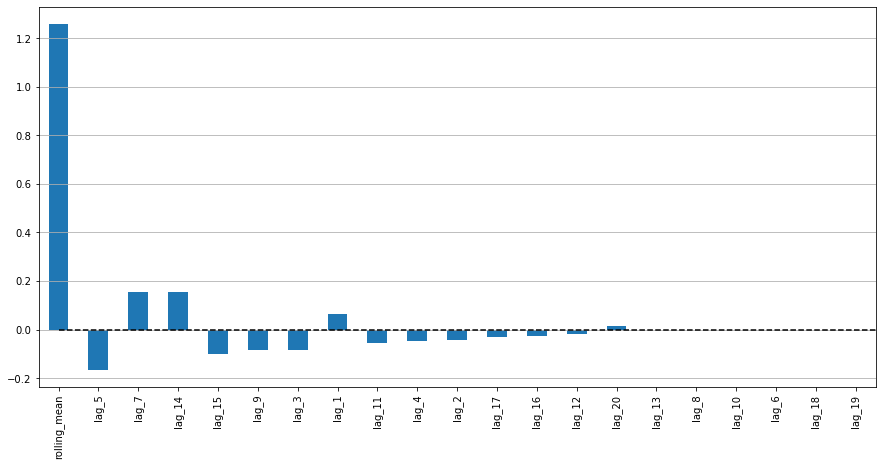

In [23]:
lasso = LassoCV(cv=tscv)
lasso.fit(X_train, y_train)

plotModelResults(lasso, 
                 X_train=X_train, 
                 X_test=X_test, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(lasso)